1. Load Dataset
2. Transform Dataset
3. seq2seq

# Load Dataset

In [13]:
# Install required libraries
!pip install -q kaggle

ERROR: Operation cancelled by user


In [14]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [15]:
api_token = {"username":"here","key":"here"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

In [16]:
# change file permission for kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [17]:
# download ocr dataset
!kaggle datasets download -d aidapearson/ocr-data

ocr-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [18]:
!unzip ocr-data.zip

Archive:  ocr-data.zip
replace batch_1/JSON/kaggle_data_1.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Transform Dataset

In [1]:
import json
import pandas as pd

In [2]:
with open(file='batch_1/JSON/kaggle_data_1.json') as f:
    raw_data = json.load(f)

In [3]:
df = pd.DataFrame(raw_data)

In [4]:
df.loc[0, "image_data"].keys()

dict_keys(['full_latex_chars', 'visible_latex_chars', 'visible_char_map', 'width', 'height', 'depth', 'xmins', 'xmaxs', 'ymins', 'ymaxs', 'xmins_raw', 'xmaxs_raw', 'ymins_raw', 'ymaxs_raw', 'png_masks'])

In [5]:
def extract_features(row):
    return pd.Series({
        'image_id': row['uuid'],
        'width': row['image_data']['width'],
        'height': row['image_data']['height'],
        'x1': row['image_data']['xmins'],
        'x2': row['image_data']['xmaxs'],
        'y1': row['image_data']['ymaxs'],
        'y2': row['image_data']['ymins'],
        'labels': row['image_data']['visible_char_map'],
        'latex': row['latex'],
        'source': f"batch_1/background_images/{row['filename']}"
        })

df = df.apply(extract_features, axis=1)

In [6]:
df.head(3)

,image_id,width,height,x1,x2,y1,y2,labels,latex,source
0,bd85ee85-2549-4539-9cd9-122d0ea3dca2,1869,497,"[0.0074946467, 0.0016059957, 0.0273019272, 0.0...","[0.1322269807, 0.0251605996, 0.0551391863, 0.1...","[0.5060483871, 0.7076612903, 0.6794354839, 0.6...","[0.25, 0.5786290323, 0.6370967742, 0.653225806...","[71, 51, 75, 7, 18, 35, 7, 7, 54, 54, 51, 12, ...",\lim_{a\to\frac{\pi}{4}}\frac{\frac{d}{da}\lef...,batch_1/background_images/bd85ee85-2549-4539-9...
1,e97b0b1f-08bf-4c2b-86cb-f264af2160df,1271,473,"[0.1031496063, 0.0070866142, 0.0385826772, 0.0...","[0.242519685, 0.0377952756, 0.0763779528, 0.18...","[0.4300847458, 0.8453389831, 0.8199152542, 0.7...","[0.218220339, 0.7775423729, 0.7690677966, 0.52...","[71, 67, 75, 18, 30, 36, 28, 7, 80, 33, 67, 33...",\lim_{w\to\pi/5^{-}}\frac{\tan^{2}{w}}{2\frac{...,batch_1/background_images/e97b0b1f-08bf-4c2b-8...
2,3c72e1a1-c1de-4d67-a0ad-9f7afb6cee01,984,381,"[0.003051882, 0.1047812818, 0.3031536114, 0.37...","[0.0935910478, 0.2919633774, 0.3692777213, 0.4...","[0.9526315789, 0.6105263158, 0.8289473684, 0.8...","[0.6105263158, 0.2447368421, 0.6131578947, 0.7...","[55, 71, 52, 75, 35, 26, 7, 7, 38, 52, 26, 34,...",e^{\lim_{b\to4^{+}}\frac{\frac{7}{b+3}}{\cos{b}}},batch_1/background_images/3c72e1a1-c1de-4d67-a...


In [7]:
def convert_to_bounding_boxes(row):
    x1 = row['x1']
    y2 = row['y2']
    x2 = row['x2']
    y1 = row['y1']
    boxes = [[x1[i], y1[i], x2[i], y2[i]] for i in range(len(x1))]
    return boxes

df['boxes'] = df.apply(convert_to_bounding_boxes, axis=1)

In [8]:
def get_cropped_dimensions(row):
    x1 = row['x1']
    y2 = row['y2']
    x2 = row['x2']
    y1 = row['y1']
    w = row["width"]
    h = row["height"]
    boxes = [[x1[i] * w, y1[i] * h, x2[i] * w, y2[i] * h] for i in range(len(x1))]
    return boxes

df['cropped_boxes'] = df.apply(get_cropped_dimensions, axis=1)

In [9]:
df =df.groupby('image_id').agg({
    'boxes': list,
    'cropped_boxes': list,
    'labels': 'first',
    'latex': 'first',
    'width': 'first',
    'height': 'first',
    'source': 'first'
}).reset_index()

In [10]:
df["boxes"] = df["boxes"].apply(lambda x: x[0])
df["cropped_boxes"] = df["cropped_boxes"].apply(lambda x: x[0])

In [11]:
df.head(3)

,image_id,boxes,cropped_boxes,labels,latex,width,height,source
0,00063690-954d-42e7-86eb-434d9416ead3,"[[0.0038461538, 0.5760598504, 0.1621794872, 0....","[[6.0038460818, 231.57605986079997, 253.162179...","[71, 66, 75, 34, 7, 7, 54, 54, 66, 12, 55, 66,...",\lim_{v\to3}\frac{\frac{d}{dv}\left(e^{v}+-2\s...,1561,402,batch_1/background_images/00063690-954d-42e7-8...
1,00095b3c-cd87-4326-addc-9225a6042407,"[[0.0046484602, 0.6420454545, 0.1301568855, 0....","[[8.0046484644, 226.6420454385, 224.1301568310...","[71, 53, 75, 7, 18, 34, 7, 76, 40, 53, 26, 80,...",\lim_{c\to\frac{\pi}{3}}\frac{\cos^{9}{c}+\tan...,1722,353,batch_1/background_images/00095b3c-cd87-4326-a...
2,000f3f60-c994-4df4-81ca-0c10e3feb67c,"[[0.018707483, 0.2995780591, 0.1167800454, 0.0...","[[33.018707495, 142.2995780725, 206.116780131,...","[71, 51, 75, 10, 7, 40, 51, 28, 33, 12, 7, 40,...",\lim_{a\to\infty}\frac{9}{a^{-2}}\left(\frac{9...,1765,475,batch_1/background_images/000f3f60-c994-4df4-8...


# Load Model
source: https://huggingface.co/docs/transformers/en/model_doc/visual_bert

VisualBERT consists of a stack of Transformer layers that implicitly align elements of an input text and regions in an associated input image with self-attention.

In [10]:
from transformers import AutoTokenizer, VisualBertConfig, VisualBertModel

# Initializing a VisualBERT visualbert-vqa-coco-pre style configuration
configuration = VisualBertConfig.from_pretrained("uclanlp/visualbert-vqa-coco-pre")

# Initializing a model (with random weights) from the visualbert-vqa-coco-pre style configuration
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = VisualBertModel.from_pretrained("uclanlp/visualbert-vqa-coco-pre")

# Accessing the model configuration
configuration = model.config

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# Process Images

In [201]:
import torch, torchvision
import matplotlib.pyplot as plt
import json
import cv2
import numpy as np
from copy import deepcopy

In [202]:
!pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-31gpyh4q
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-31gpyh4q
  Resolved https://github.com/facebookresearch/detectron2.git to commit b7c7f4ba82192ff06f2bbb162b9f67b00ea55867
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=576

In [203]:
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures.image_list import ImageList
from detectron2.data import transforms as T
from detectron2.modeling.box_regression import Box2BoxTransform
# from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputs
from detectron2.structures.boxes import Boxes
from detectron2.layers import nms
from detectron2 import model_zoo
from detectron2.config import get_cfg

In [204]:
from detectron2.layers import ShapeSpec, batched_nms, cat, cross_entropy, nonzero_tuple
from fvcore.nn import giou_loss, smooth_l1_loss
from detectron2.modeling.box_regression import Box2BoxTransform
from detectron2.structures import Boxes
import torch.nn.functional as F


class FastRCNNOutputs:
    """
    An internal implementation that stores information about outputs of a Fast R-CNN head,
    and provides methods that are used to decode the outputs of a Fast R-CNN head.
    """

    def __init__(
        self,
        box2box_transform,
        pred_class_logits,
        pred_proposal_deltas,
        proposals,
        smooth_l1_beta=0.0,
        box_reg_loss_type="smooth_l1",
    ):
        """
        Args:
            box2box_transform (Box2BoxTransform/Box2BoxTransformRotated):
                box2box transform instance for proposal-to-detection transformations.
            pred_class_logits (Tensor): A tensor of shape (R, K + 1) storing the predicted class
                logits for all R predicted object instances.
                Each row corresponds to a predicted object instance.
            pred_proposal_deltas (Tensor): A tensor of shape (R, K * B) or (R, B) for
                class-specific or class-agnostic regression. It stores the predicted deltas that
                transform proposals into final box detections.
                B is the box dimension (4 or 5).
                When B is 4, each row is [dx, dy, dw, dh (, ....)].
                When B is 5, each row is [dx, dy, dw, dh, da (, ....)].
            proposals (list[Instances]): A list of N Instances, where Instances i stores the
                proposals for image i, in the field "proposal_boxes".
                When training, each Instances must have ground-truth labels
                stored in the field "gt_classes" and "gt_boxes".
                The total number of all instances must be equal to R.
            smooth_l1_beta (float): The transition point between L1 and L2 loss in
                the smooth L1 loss function. When set to 0, the loss becomes L1. When
                set to +inf, the loss becomes constant 0.
            box_reg_loss_type (str): Box regression loss type. One of: "smooth_l1", "giou"
        """
        self.box2box_transform = box2box_transform
        self.num_preds_per_image = [len(p) for p in proposals]
        self.pred_class_logits = pred_class_logits
        self.pred_proposal_deltas = pred_proposal_deltas
        self.smooth_l1_beta = smooth_l1_beta
        self.box_reg_loss_type = box_reg_loss_type

        self.image_shapes = [x.image_size for x in proposals]

        if len(proposals):
            box_type = type(proposals[0].proposal_boxes)
            # cat(..., dim=0) concatenates over all images in the batch
            self.proposals = box_type.cat([p.proposal_boxes for p in proposals])
            assert (
                not self.proposals.tensor.requires_grad
            ), "Proposals should not require gradients!"

            # "gt_classes" exists if and only if training. But other gt fields may
            # not necessarily exist in training for images that have no groundtruth.
            if proposals[0].has("gt_classes"):
                self.gt_classes = cat([p.gt_classes for p in proposals], dim=0)

                # If "gt_boxes" does not exist, the proposals must be all negative and
                # should not be included in regression loss computation.
                # Here we just use proposal_boxes as an arbitrary placeholder because its
                # value won't be used in self.box_reg_loss().
                gt_boxes = [
                    p.gt_boxes if p.has("gt_boxes") else p.proposal_boxes for p in proposals
                ]
                self.gt_boxes = box_type.cat(gt_boxes)
        else:
            self.proposals = Boxes(torch.zeros(0, 4, device=self.pred_proposal_deltas.device))
        self._no_instances = len(self.proposals) == 0  # no instances found

    def softmax_cross_entropy_loss(self):
        """
        Deprecated
        """
        _log_classification_stats(self.pred_class_logits, self.gt_classes)
        return cross_entropy(self.pred_class_logits, self.gt_classes, reduction="mean")

    def box_reg_loss(self):
        """
        Deprecated
        """
        if self._no_instances:
            return 0.0 * self.pred_proposal_deltas.sum()

        box_dim = self.proposals.tensor.size(1)  # 4 or 5
        cls_agnostic_bbox_reg = self.pred_proposal_deltas.size(1) == box_dim
        device = self.pred_proposal_deltas.device

        bg_class_ind = self.pred_class_logits.shape[1] - 1
        # Box delta loss is only computed between the prediction for the gt class k
        # (if 0 <= k < bg_class_ind) and the target; there is no loss defined on predictions
        # for non-gt classes and background.
        # Empty fg_inds should produce a valid loss of zero because reduction=sum.
        fg_inds = nonzero_tuple((self.gt_classes >= 0) & (self.gt_classes < bg_class_ind))[0]

        if cls_agnostic_bbox_reg:
            # pred_proposal_deltas only corresponds to foreground class for agnostic
            gt_class_cols = torch.arange(box_dim, device=device)
        else:
            # pred_proposal_deltas for class k are located in columns [b * k : b * k + b],
            # where b is the dimension of box representation (4 or 5)
            # Note that compared to Detectron1,
            # we do not perform bounding box regression for background classes.
            gt_class_cols = box_dim * self.gt_classes[fg_inds, None] + torch.arange(
                box_dim, device=device
            )

        if self.box_reg_loss_type == "smooth_l1":
            gt_proposal_deltas = self.box2box_transform.get_deltas(
                self.proposals.tensor, self.gt_boxes.tensor
            )
            loss_box_reg = smooth_l1_loss(
                self.pred_proposal_deltas[fg_inds[:, None], gt_class_cols],
                gt_proposal_deltas[fg_inds],
                self.smooth_l1_beta,
                reduction="sum",
            )
        elif self.box_reg_loss_type == "giou":
            fg_pred_boxes = self.box2box_transform.apply_deltas(
                self.pred_proposal_deltas[fg_inds[:, None], gt_class_cols],
                self.proposals.tensor[fg_inds],
            )
            loss_box_reg = giou_loss(
                fg_pred_boxes,
                self.gt_boxes.tensor[fg_inds],
                reduction="sum",
            )
        else:
            raise ValueError(f"Invalid bbox reg loss type '{self.box_reg_loss_type}'")

        loss_box_reg = loss_box_reg / self.gt_classes.numel()
        return loss_box_reg

    def losses(self):
        """
        Deprecated
        """
        return {"loss_cls": self.softmax_cross_entropy_loss(), "loss_box_reg": self.box_reg_loss()}

    def predict_boxes(self):
        """
        Deprecated
        """
        pred = self.box2box_transform.apply_deltas(self.pred_proposal_deltas, self.proposals.tensor)
        return pred.split(self.num_preds_per_image, dim=0)

    def predict_probs(self):
        """
        Deprecated
        """
        probs = F.softmax(self.pred_class_logits, dim=-1)
        return probs.split(self.num_preds_per_image, dim=0)


In [205]:
import torch

print("PyTorch version:")
print(torch.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

PyTorch version:
2.2.1+cu121
Using cpu device


In [206]:
cfg_path = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"

def load_config_and_model_weights(cfg_path):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(cfg_path))

    # ROI HEADS SCORE THRESHOLD
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

    # Comment the next line if you're using 'cuda'
    cfg['MODEL']['DEVICE']='cpu'

    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(cfg_path)

    return cfg

cfg = load_config_and_model_weights(cfg_path)

In [231]:
# load object detection model
def get_model(cfg):
    # build model
    model = build_model(cfg)

    # load weights
    checkpointer = DetectionCheckpointer(model)
    checkpointer.load(cfg.MODEL.WEIGHTS)

    # eval mode
    model.eval()
    return model

model = get_model(cfg)

In [232]:
model.eval()

GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

In [209]:
# convert image to model input

def prepare_image_inputs(cfg, img_list):
    # Resizing the image according to the configuration
    transform_gen = T.ResizeShortestEdge(
                [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
            )
    img_list = [transform_gen.get_transform(img).apply_image(img) for img in img_list]

    # Convert to C,H,W format
    convert_to_tensor = lambda x: torch.Tensor(x.astype("float32").transpose(2, 0, 1))

    batched_inputs = [{"image":convert_to_tensor(img), "height": img.shape[0], "width": img.shape[1]} for img in img_list]

    # Normalizing the image
    num_channels = len(cfg.MODEL.PIXEL_MEAN)
    pixel_mean = torch.Tensor(cfg.MODEL.PIXEL_MEAN).view(num_channels, 1, 1)
    pixel_std = torch.Tensor(cfg.MODEL.PIXEL_STD).view(num_channels, 1, 1)
    normalizer = lambda x: (x - pixel_mean) / pixel_std
    images = [normalizer(x["image"]) for x in batched_inputs]

    # Convert to ImageList
    images =  ImageList.from_tensors(images,model.backbone.size_divisibility)

    return images, batched_inputs

img1 = plt.imread(df.loc[0, "source"])
img2 = plt.imread(df.loc[1, "source"])

# Detectron expects BGR images
img_bgr1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
img_bgr2 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)

images, batched_inputs = prepare_image_inputs(cfg, [img_bgr1, img_bgr2])

In [228]:
def prepare_image_input(cfg, img):
    # Resizing the image according to the configuration
    transform_gen = T.ResizeShortestEdge(
        [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
    )
    img = transform_gen.get_transform(img).apply_image(img)

    # Convert to C,H,W format
    convert_to_tensor = lambda x: torch.Tensor(x.astype("float32").transpose(2, 0, 1))

    # Create a dictionary containing image and its size
    batched_input = {"image": convert_to_tensor(img), "height": img.shape[0], "width": img.shape[1]}

    # Normalizing the image
    num_channels = len(cfg.MODEL.PIXEL_MEAN)
    pixel_mean = torch.Tensor(cfg.MODEL.PIXEL_MEAN).view(num_channels, 1, 1)
    pixel_std = torch.Tensor(cfg.MODEL.PIXEL_STD).view(num_channels, 1, 1)
    normalizer = lambda x: (x - pixel_mean) / pixel_std
    image = normalizer(batched_input["image"])

    # Convert to ImageList
    image = ImageList.from_tensors([image], model.backbone.size_divisibility)

    return image, batched_input


In [211]:
# get resnet + fpn features

def get_features(model, images):
    features = model.backbone(images.tensor)
    return features

features = get_features(model, images)

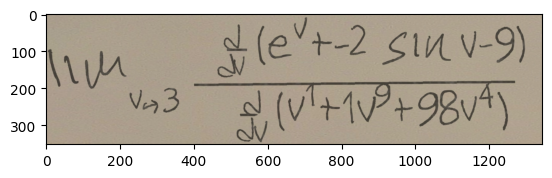

torch.Size([2, 256, 88, 336])


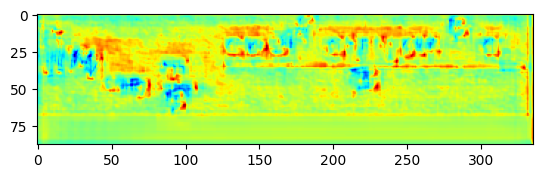

torch.Size([2, 256, 44, 168])


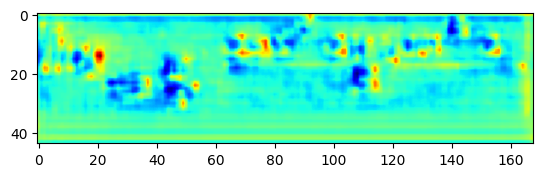

torch.Size([2, 256, 22, 84])


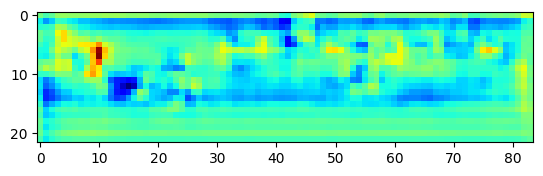

torch.Size([2, 256, 11, 42])


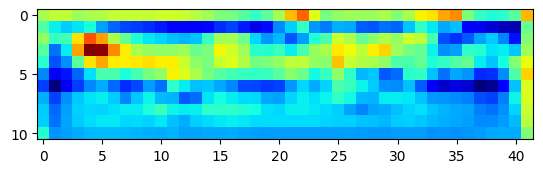

torch.Size([2, 256, 6, 21])


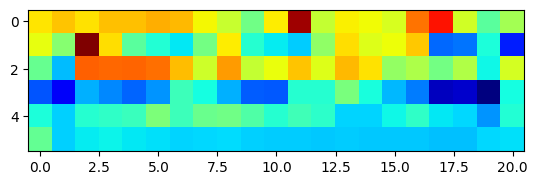

In [212]:
plt.imshow(cv2.resize(img1, (images.tensor.shape[-2:][::-1])))
plt.show()
for key in features.keys():
    print(features[key].shape)
    plt.imshow(features[key][1,0,:,:].squeeze().detach().numpy(), cmap='jet')
    plt.show()

In [213]:
cfg.MODEL.PROPOSAL_GENERATOR.NAME

'RPN'

In [214]:
proposals, _ = model.proposal_generator(images, features)

In [236]:
def get_box_features(model, features, proposals):
    features_list = [features[f] for f in ['p2', 'p3', 'p4', 'p5']]
    box_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
    box_features = model.roi_heads.box_head.flatten(box_features)
    box_features = model.roi_heads.box_head.fc1(box_features)
    box_features = model.roi_heads.box_head.fc_relu1(box_features)
    box_features = model.roi_heads.box_head.fc2(box_features)

    box_features = box_features.reshape(2, 1000, 1024) # depends on your config and batch size
    return box_features, features_list

box_features, features_list = get_box_features(model, features, proposals)

In [216]:
def get_prediction_logits(model, features_list, proposals):
    cls_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
    cls_features = model.roi_heads.box_head(cls_features)
    pred_class_logits, pred_proposal_deltas = model.roi_heads.box_predictor(cls_features)
    return pred_class_logits, pred_proposal_deltas

pred_class_logits, pred_proposal_deltas = get_prediction_logits(model, features_list, proposals)

In [217]:
def get_box_scores(cfg, pred_class_logits, pred_proposal_deltas):
    box2box_transform = Box2BoxTransform(weights=cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS)
    smooth_l1_beta = cfg.MODEL.ROI_BOX_HEAD.SMOOTH_L1_BETA

    outputs = FastRCNNOutputs(
        box2box_transform,
        pred_class_logits,
        pred_proposal_deltas,
        proposals,
        smooth_l1_beta,
    )

    boxes = outputs.predict_boxes()
    scores = outputs.predict_probs()
    image_shapes = outputs.image_shapes

    return boxes, scores, image_shapes

boxes, scores, image_shapes = get_box_scores(cfg, pred_class_logits, pred_proposal_deltas)

In [218]:
def get_output_boxes(boxes, batched_inputs, image_size):
    proposal_boxes = boxes.reshape(-1, 4).clone()
    scale_x, scale_y = (batched_inputs["width"] / image_size[1], batched_inputs["height"] / image_size[0])
    output_boxes = Boxes(proposal_boxes)

    output_boxes.scale(scale_x, scale_y)
    output_boxes.clip(image_size)

    return output_boxes

output_boxes = [get_output_boxes(boxes[i], batched_inputs[i], proposals[i].image_size) for i in range(len(proposals))]

In [219]:
def select_boxes(cfg, output_boxes, scores):
    test_score_thresh = cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST
    test_nms_thresh = cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST
    cls_prob = scores.detach()
    cls_boxes = output_boxes.tensor.detach().reshape(1000,80,4)
    max_conf = torch.zeros((cls_boxes.shape[0]))
    for cls_ind in range(0, cls_prob.shape[1]-1):
        cls_scores = cls_prob[:, cls_ind+1]
        det_boxes = cls_boxes[:,cls_ind,:]
        keep = np.array(nms(det_boxes, cls_scores, test_nms_thresh))
        max_conf[keep] = torch.where(cls_scores[keep] > max_conf[keep], cls_scores[keep], max_conf[keep])
    keep_boxes = torch.where(max_conf >= test_score_thresh)[0]
    return keep_boxes, max_conf

In [220]:
temp = [select_boxes(cfg, output_boxes[i], scores[i]) for i in range(len(scores))]
keep_boxes, max_conf = [],[]
for keep_box, mx_conf in temp:
    keep_boxes.append(keep_box)
    max_conf.append(mx_conf)

In [221]:
MIN_BOXES=10
MAX_BOXES=100
def filter_boxes(keep_boxes, max_conf, min_boxes, max_boxes):
    if len(keep_boxes) < min_boxes:
        keep_boxes = np.argsort(max_conf).numpy()[::-1][:min_boxes]
    elif len(keep_boxes) > max_boxes:
        keep_boxes = np.argsort(max_conf).numpy()[::-1][:max_boxes]
    return keep_boxes

keep_boxes = [filter_boxes(keep_box, mx_conf, MIN_BOXES, MAX_BOXES) for keep_box, mx_conf in zip(keep_boxes, max_conf)]

In [222]:
def get_visual_embeds(box_features, keep_boxes):
    return box_features[keep_boxes.copy()]

visual_embeds = [get_visual_embeds(box_feature, keep_box) for box_feature, keep_box in zip(box_features, keep_boxes)]

In [223]:
visual_embeds

[tensor([[-0.5428,  0.4427, -1.4199,  ..., -2.8775, -4.1177,  1.3297],
         [-0.5155,  0.1069, -0.1599,  ..., -1.7807, -1.4794, -0.4866],
         [-0.1345,  1.3881, -1.4437,  ..., -1.2935, -1.2225,  0.1750],
         ...,
         [ 2.6908,  0.6013, -0.2240,  ..., -2.0214,  0.7325, -1.5646],
         [ 1.0782,  1.8218,  0.0868,  ..., -2.3675,  0.3923, -0.5975],
         [ 2.2758,  1.3537, -0.2624,  ..., -2.5952, -0.1620, -0.9302]],
        grad_fn=<IndexBackward0>),
 tensor([[ 0.3712,  0.7906, -0.7441,  ..., -2.5303, -1.1994,  0.6250],
         [-0.6258, -0.7287,  0.1804,  ..., -1.0892,  0.0491,  0.0544],
         [ 1.6237, -0.3060, -0.7659,  ..., -2.5163, -1.7224,  0.4518],
         ...,
         [ 0.4044,  1.1605,  0.3355,  ..., -1.4510, -0.1752, -0.1096],
         [ 1.2994, -0.4412, -0.6511,  ..., -1.6137,  0.0909, -0.4063],
         [ 0.8132,  2.5333,  0.0315,  ..., -3.3500, -0.8065, -0.2805]],
        grad_fn=<IndexBackward0>)]

In [224]:
from transformers import BertTokenizer, VisualBertForPreTraining

In [230]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
visbert = VisualBertForPreTraining.from_pretrained("uclanlp/visualbert-vqa-coco-pre")

In [226]:
def get_visual_embeddings(images):
  img_bgr = [cv2.cvtColor(plt.imread(img), cv2.COLOR_RGB2BGR) for img in images]
  images, batched_input = prepare_image_inputs(cfg, img_bgr)
  features = get_features(model, images)
  proposals, _ = model.proposal_generator(images, features)
  box_features, features_list = get_box_features(model, features, proposals)
  pred_class_logits, pred_proposal_deltas = get_prediction_logits(model, features_list, proposals)
  boxes, scores, image_shapes = get_box_scores(cfg, pred_class_logits, pred_proposal_deltas)
  output_boxes = [get_output_boxes(boxes[i], batched_inputs[i], proposals[i].image_size) for i in range(len(proposals))]
  temp = [select_boxes(cfg, output_boxes[i], scores[i]) for i in range(len(scores))]
  keep_boxes, max_conf = [],[]
  for keep_box, mx_conf in temp:
      keep_boxes.append(keep_box)
      max_conf.append(mx_conf)
  keep_boxes = [filter_boxes(keep_box, mx_conf, MIN_BOXES, MAX_BOXES) for keep_box, mx_conf in zip(keep_boxes, max_conf)]
  visual_embeds = [get_visual_embeds(box_feature, keep_box) for box_feature, keep_box in zip(box_features, keep_boxes)]
  return visual_embeds

In [237]:
# Define your image and caption
image = df.loc[0, "source"]  # Your image
caption = df.loc[0, "latex"]

# Tokenize and encode the caption
inputs = tokenizer(caption, return_tensors="pt")
caption_input_ids = inputs["input_ids"]
caption_attention_mask = inputs["attention_mask"]

# Get visual embeddings for the image
visual_embeds = get_visual_embeddings(image).unsqueeze(0)
visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.float)

# Prepare inputs for the model
inputs = {
    "input_ids": caption_input_ids,
    "attention_mask": caption_attention_mask,
    "visual_embeds": visual_embeds,
    "visual_token_type_ids": visual_token_type_ids,
    "visual_attention_mask": visual_attention_mask,
}

# Generate labels for the caption
max_length = caption_input_ids.shape[-1] + visual_embeds.shape[-2]
labels = tokenizer(caption, return_tensors="pt", padding="max_length", max_length=max_length)["input_ids"]
sentence_image_labels = torch.tensor(1).unsqueeze(0)  # Assuming one image-caption pair in this example

# Forward pass through the model
outputs = model(**inputs, labels=labels, sentence_image_labels=sentence_image_labels)
loss = outputs.loss

ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [244]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Example input data (bounding boxes and labels)
# Assuming each bounding box is represented by a 1D array of features
# and each label is a LaTeX string

# Bounding box features (example)
bounding_boxes = df.loc[0, "boxes"]

# Associated LaTeX labels
latex_labels = [
    "\\lim_{v\\to3}\\frac{\\frac{d}{dv}\\left(e^{v}+-2\\sin{v}-9\\right)}{\\frac{d}{dv}\\left(v^{1}+1v^{9}+98v^{4}\\right)}",  # Example label 1
    "\\frac{1}{2}",  # Example label 2
    # Add more LaTeX labels as needed
]

# Define a seq2seq model with attention
class Seq2SeqWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Seq2SeqWithAttention, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, output_size)
        self.attention = nn.Linear(hidden_size * 2, 1)

    def forward(self, input, decoder_hidden):
        encoded = self.encoder(input)
        attention_weights = self.attention(torch.cat([encoded, decoder_hidden.unsqueeze(1)], dim=2)).squeeze(2)
        attention_weights = torch.softmax(attention_weights, dim=1)
        context_vector = torch.sum(encoded * attention_weights.unsqueeze(2), dim=1)
        decoded = self.decoder(context_vector)
        return decoded, attention_weights

# Preprocess input data
input_data = torch.tensor(bounding_boxes, dtype=torch.float32)
target_data = [label.split("\\") for label in latex_labels]  # Tokenize LaTeX strings

# Define model parameters
input_size = len(bounding_boxes[0])
hidden_size = 128
output_size = 256  # Assuming the vocabulary size of the LaTeX characters is 256

# Instantiate the model
model = Seq2SeqWithAttention(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    decoder_hidden = torch.zeros((len(input_data), hidden_size))
    loss = 0
    for timestep in range(max(len(label) for label in target_data)):
        decoder_input = torch.tensor([[char_to_idx[label[timestep]] if timestep < len(label) else 0 for label in target_data]], dtype=torch.long)
        decoder_output, attention_weights = model(input_data, decoder_hidden)
        loss += criterion(decoder_output, decoder_input.squeeze(0))
        decoder_hidden = decoder_output
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# Inference
with torch.no_grad():
    model.eval()
    decoder_hidden = torch.zeros((len(input_data), hidden_size))
    predicted_latex = ""
    for timestep in range(max(len(label) for label in target_data)):
        decoder_output, attention_weights = model(input_data, decoder_hidden)
        predicted_char_index = torch.argmax(decoder_output, dim=1)
        predicted_char = idx_to_char[predicted_char_index.item()]
        predicted_latex += predicted_char
        decoder_hidden = decoder_output
    print("Predicted LaTeX:", predicted_latex)

NameError: name 'label' is not defined

# Misc Tinker

In [12]:
l = df.loc[0, "latex"]

In [13]:
l

'\\lim_{v\\to3}\\frac{\\frac{d}{dv}\\left(e^{v}+-2\\sin{v}-9\\right)}{\\frac{d}{dv}\\left(v^{1}+1v^{9}+98v^{4}\\right)}'

In [14]:
import matplotlib.pyplot as plt
from PIL import Image

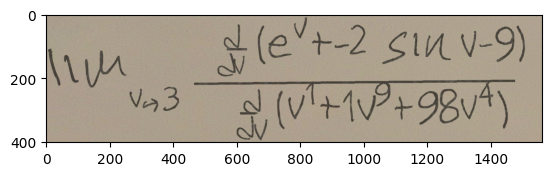

In [15]:
image_path = df.loc[0, "source"]
image = Image.open(image_path)

plt.imshow(image)

In [16]:
with open(file='extras/visible_char_map.json') as f:
    chr_map_data = json.load(f)

In [17]:
chr_map_data

{'\\alpha': 1,
 '\\approx': 2,
 '\\beta': 3,
 '\\cdot': 4,
 '\\delta': 5,
 '\\div': 6,
 '\\frac': 7,
 '\\gamma': 8,
 '\\geq': 9,
 '\\infty': 10,
 '\\int': 11,
 '\\left(': 12,
 '\\left[': 13,
 '\\left\\{': 14,
 '\\left|': 15,
 '\\leq': 16,
 '\\neq': 17,
 '\\pi': 18,
 '\\pm': 19,
 '\\prime': 20,
 '\\right)': 21,
 '\\right]': 22,
 '\\right|': 23,
 '\\sqrt': 24,
 '\\theta': 25,
 '+': 26,
 ',': 27,
 '-': 28,
 '.': 29,
 '/': 30,
 '0': 31,
 '1': 32,
 '2': 33,
 '3': 34,
 '4': 35,
 '5': 36,
 '6': 37,
 '7': 38,
 '8': 39,
 '9': 40,
 ';': 41,
 '<': 42,
 '=': 43,
 '>': 44,
 'A': 45,
 'C': 46,
 'F': 47,
 'G': 48,
 'H': 49,
 'L': 50,
 'a': 51,
 'b': 52,
 'c': 53,
 'd': 54,
 'e': 55,
 'f': 56,
 'g': 57,
 'h': 58,
 'k': 59,
 'n': 60,
 'p': 61,
 'r': 62,
 's': 63,
 't': 64,
 'u': 65,
 'v': 66,
 'w': 67,
 'x': 68,
 'y': 69,
 'z': 70,
 '\\lim_': 71,
 '\\log': 72,
 '\\cot': 73,
 '\\csc': 74,
 '\\to': 75,
 '\\cos': 76,
 '\\sec': 77,
 '\\sin': 78,
 '\\ln': 79,
 '\\tan': 80,
 '\\arcsin': 81,
 '\\arccos': 82,


In [80]:
import requests
from PIL import Image

from transformers import GPT2TokenizerFast, ViTImageProcessor, VisionEncoderDecoderModel

# load a fine-tuned image captioning model and corresponding tokenizer and image processor
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = GPT2TokenizerFast.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
image_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

# let's perform inference on an image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
pixel_values = image_processor(image, return_tensors="pt").pixel_values

# autoregressively generate caption (uses greedy decoding by default)
generated_ids = model.generate(pixel_values)
generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


a cat laying on a blanket next to a cat laying on a bed 


# Seq2seq

In [12]:
from transformers import VisionEncoderDecoderModel, AutoTokenizer, AutoFeatureExtractor

image_encoder_model = "google/vit-base-patch16-224-in21k"
text_decode_model = "gpt2"

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    image_encoder_model, text_decode_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias'

In [13]:
# image feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained(image_encoder_model)
# text tokenizer
tokenizer = AutoTokenizer.from_pretrained(text_decode_model, device="cuda")

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [14]:
# GPT2 only has bos/eos tokens but not decoder_start/pad tokens
tokenizer.pad_token = tokenizer.eos_token

# update the model config
model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

In [25]:
output_dir = "vit-gpt-model"
model.save_pretrained(output_dir)
feature_extractor.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Removed shared tensor {'decoder.lm_head.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading


('vit-gpt-model/tokenizer_config.json',
 'vit-gpt-model/special_tokens_map.json',
 'vit-gpt-model/vocab.json',
 'vit-gpt-model/merges.txt',
 'vit-gpt-model/added_tokens.json',
 'vit-gpt-model/tokenizer.json')

In [22]:
from PIL import Image

# text preprocessing step
def tokenization_fn(captions, max_target_length):
    """Run tokenization on captions."""
    labels = tokenizer(captions,
                      padding="max_length",
                      max_length=max_target_length).input_ids

    return labels

# image preprocessing step
def feature_extraction_fn(image_paths, check_image=True):
    """
    Run feature extraction on images
    If `check_image` is `True`, the examples that fails during `Image.open()` will be caught and discarded.
    Otherwise, an exception will be thrown.
    """

    model_inputs = {}

    if check_image:
        images = []
        to_keep = []
        for image_file in image_paths:
            try:
                img = Image.open(image_file)
                images.append(img)
                to_keep.append(True)
            except Exception:
                to_keep.append(False)
    else:
        images = [Image.open(image_file) for image_file in image_paths]

    encoder_inputs = feature_extractor(images=images, return_tensors="np")

    return encoder_inputs.pixel_values

def preprocess_fn(examples, max_target_length, check_image = True):
    """Run tokenization + image feature extraction"""
    image_paths = examples['source']
    captions = examples['latex']

    model_inputs = {}
    # This contains image path column
    model_inputs['labels'] = tokenization_fn(captions, max_target_length)
    model_inputs['pixel_values'] = feature_extraction_fn(image_paths, check_image=check_image)

    return model_inputs

In [23]:
subset = df.loc[:, ["latex", "source"]]

In [17]:
!pip install datasets

In [17]:
subset_sample = subset.sample(frac=0.25, random_state=42)

In [18]:
from sklearn.model_selection import train_test_split
from datasets import DatasetDict, Dataset

# Split the DataFrame into train, test, and validation sets
train_df, test_val_df = train_test_split(subset_sample, test_size=0.2, random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

# Convert pandas DataFrames to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
val_dataset = Dataset.from_pandas(val_df)

# Create a DatasetDict object to hold the datasets
ds = DatasetDict({
    'train': train_dataset,
    'test': test_dataset,
    'validation': val_dataset
})

In [19]:
ds['train']

Dataset({
    features: ['latex', 'source', '__index_level_0__'],
    num_rows: 2000
})

In [20]:
import torch

# Assuming you have a GPU device available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [21]:
processed_dataset = ds.map(
    function=preprocess_fn,
    batched=True,
    fn_kwargs={"max_target_length": 128},
    remove_columns=ds['train'].column_names
)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [28]:
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.3/297.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 354.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 556.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [32]:
!pip install transformers[torch]

In [24]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

In [25]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    output_dir="./image-captioning-output",
)

In [28]:
def compute_metrics():
  None

In [30]:
from transformers import default_data_collator

In [31]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=feature_extractor,
    args=training_args,
    train_dataset=processed_dataset['train'],
    eval_dataset=processed_dataset['validation'],
    data_collator=default_data_collator,
)

In [32]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.229900,0.237933
2,0.213200,0.208134
3,0.188100,0.199771


Checkpoint destination directory ./image-captioning-output/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=1500, training_loss=0.2104197743733724, metrics={'train_runtime': 1433.6441, 'train_samples_per_second': 4.185, 'train_steps_per_second': 1.046, 'total_flos': 1.082783346720768e+18, 'train_loss': 0.2104197743733724, 'epoch': 3.0})

In [36]:
trainer.save_model("./image-captioning-output")

In [37]:
tokenizer.save_pretrained("./image-captioning-output")

('./image-captioning-output/tokenizer_config.json',
 './image-captioning-output/special_tokens_map.json',
 './image-captioning-output/vocab.json',
 './image-captioning-output/merges.txt',
 './image-captioning-output/added_tokens.json',
 './image-captioning-output/tokenizer.json')

In [33]:
from transformers import pipeline

In [38]:
image_captioner = pipeline("image-to-text", model="image-captioning-output")

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [40]:
image_captioner(df.loc[0, "source"])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': '\\lim_{x\\to2^{+}}\\frac{\\frac{d}{dx}\\'}]

In [41]:
df.loc[0, "latex"]

'\\lim_{v\\to3}\\frac{\\frac{d}{dv}\\left(e^{v}+-2\\sin{v}-9\\right)}{\\frac{d}{dv}\\left(v^{1}+1v^{9}+98v^{4}\\right)}'